In [8]:
import os
import csv
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.utils as utils
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.models import vgg16_bn
from sklearn.metrics import confusion_matrix

In [9]:
class AttentionBlock(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv2d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv2d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
    def forward(self, l, g):
        N, C, W, H = l.size()
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        if self.up_factor > 1:
            g_ = F.interpolate(g_, scale_factor=self.up_factor, mode='bilinear', align_corners=False)
        c = self.phi(F.relu(l_ + g_)) # batch_sizex1xWxH
        
        # compute attn map
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxWxH
        if self.normalize_attn:
            output = f.view(N,C,-1).sum(dim=2) # weighted sum
        else:
            output = F.adaptive_avg_pool2d(f, (1,1)).view(N,C) # global average pooling
        return a, output

In [10]:
class AttnVGG(nn.Module):
    def __init__(self, num_classes, normalize_attn=False, dropout=None):
        super(AttnVGG, self).__init__()
        net = models.vgg16_bn(weights=torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1)
        self.conv_block1 = nn.Sequential(*list(net.features.children())[0:6])
        self.conv_block2 = nn.Sequential(*list(net.features.children())[7:13])
        self.conv_block3 = nn.Sequential(*list(net.features.children())[14:23])
        self.conv_block4 = nn.Sequential(*list(net.features.children())[24:33])
        self.conv_block5 = nn.Sequential(*list(net.features.children())[34:43])
        self.pool = nn.AvgPool2d(7, stride=1)
        self.dpt = None
        if dropout is not None:
            self.dpt = nn.Dropout(dropout)
        self.cls = nn.Linear(in_features=512+512+256, out_features=num_classes, bias=True)
        
       # initialize the attention blocks defined above
        self.attn1 = AttentionBlock(256, 512, 256, 4, normalize_attn=normalize_attn)
        self.attn2 = AttentionBlock(512, 512, 256, 2, normalize_attn=normalize_attn)
        
       
        self.reset_parameters(self.cls)
        self.reset_parameters(self.attn1)
        self.reset_parameters(self.attn2)
    def reset_parameters(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)
    def forward(self, x):
        block1 = self.conv_block1(x)       # /1
        pool1 = F.max_pool2d(block1, 2, 2) # /2
        block2 = self.conv_block2(pool1)   # /2
        pool2 = F.max_pool2d(block2, 2, 2) # /4
        block3 = self.conv_block3(pool2)   # /4
        pool3 = F.max_pool2d(block3, 2, 2) # /8
        block4 = self.conv_block4(pool3)   # /8
        pool4 = F.max_pool2d(block4, 2, 2) # /16
        block5 = self.conv_block5(pool4)   # /16
        pool5 = F.max_pool2d(block5, 2, 2) # /32
        N, __, __, __ = pool5.size()
        
        g = self.pool(pool5).view(N,512)
        a1, g1 = self.attn1(pool3, pool5)
        a2, g2 = self.attn2(pool4, pool5)
        g_hat = torch.cat((g,g1,g2), dim=1) # batch_size x C
        if self.dpt is not None:
            g_hat = self.dpt(g_hat)
        out = self.cls(g_hat)

        return [out, a1, a2]

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_ids = [0]

root_dir = "/home/rishab/alexnet_attention/test"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
testset = datasets.ImageFolder(root=root_dir,transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 0 -> Advertisement


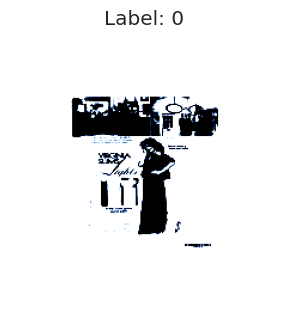

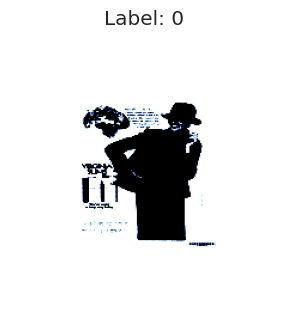

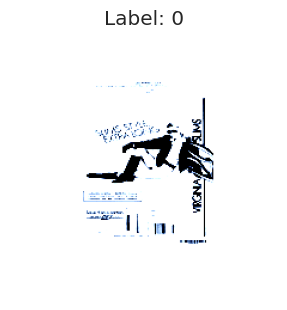

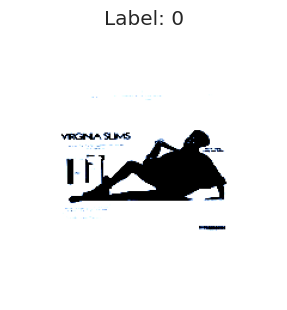

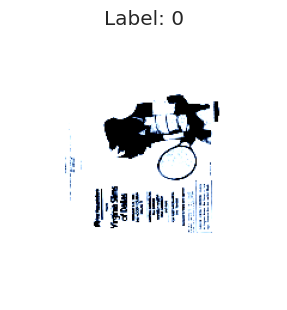

In [12]:
num_samples_to_display = 5
sample_indices = range(num_samples_to_display)
samples = [testset[i] for i in sample_indices]

# Display the sample images and labels
for i, (sample_image, sample_label) in enumerate(samples):
    # Convert sample image tensor to NumPy array
    sample_image_np = np.transpose(sample_image.numpy(), (1, 2, 0))
    plt.figure(figsize=(20,10))
    plt.subplot(1, num_samples_to_display, i+1)
    plt.imshow(sample_image_np)
    plt.title(f"Label: {sample_label}")
    plt.axis("off")
print("Label: 0 -> Advertisement")
plt.show()

In [13]:
num_classes = 16

net = AttnVGG(num_classes=16,normalize_attn=True)
checkpoint = torch.load("last_model.pth")
net.load_state_dict(checkpoint)
model = nn.DataParallel(net, device_ids=device_ids).to(device)
model.eval()

#Testing
writer = SummaryWriter("logs")
all_preds = []
all_labels = []
with torch.no_grad():
    total = 0
    correct = 0
    for images,labels in testloader:
        inputs = images.to(device)
        labels = labels.to(device)
        pred_test,_,_ = model(inputs)
        _,predict = torch.max(pred_test, 1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()
        all_preds.extend(predict.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
# Calculate and print accuracy
print("Correct_Predictions",correct)
print("Total",total)
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")

# Confusuion Matrix
CM = confusion_matrix(all_labels, all_preds, labels=list(range(16)))


acc = np.sum(np.diag(CM)) / np.sum(CM)

print('\nTestset Accuracy(mean): %f %%' % (100 * acc))
print()
print('Confusion Matirx : ')
print(CM)

class_sensitivity = []
class_precision = []
class_metrics = []

csv_filename = "test_results.csv"
with open(csv_filename, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)

    writer.writerow(["Class","Sensitivity","Precision"])
    for class_idx in range(num_classes):
        tp = CM[class_idx, class_idx]
        fn = np.sum(CM[class_idx, :]) - tp
        fp = np.sum(CM[:, class_idx]) - tp
        tn = np.sum(CM) - tp - fn - fp
        
        sensitivity = tp / (tp + fn)
        precision = tp / (tp + fp)
        class_sensitivity.append(sensitivity)
        class_precision.append(precision)

        writer.writerow([f"Class {class_idx}"])
        writer.writerow(["Sensitivity",sensitivity])
        writer.writerow(["Precision", precision])
        class_metrics.append([sensitivity, precision])
        
        # Write mean metrics
        mean_sensitivity = np.mean(class_sensitivity)
        mean_precision = np.mean(class_precision)
        writer.writerow(["Mean Sensitivity", mean_sensitivity])
        writer.writerow(["Mean Precision", mean_precision])

        print(f'Class {class_idx}:')
        print('- Sensitivity:', sensitivity)
        print('- Precision:', precision)
        print()
    
    # Write confusion matrix
    writer.writerow([])
    writer.writerow(["Confusion Matrix"])
    writer.writerows(CM)
  
print('Mean Sensitivity:', mean_sensitivity)
print('Mean Precision:', mean_precision)

Correct_Predictions 2088
Total 3200
Accuracy: 65.25%

Testset Accuracy(mean): 65.250000 %

Confusion Matirx : 
[[191   0   0   0   4   2   0   0   0   1   0   2   0   0   0   0]
 [  0  69   2   7  20   0   5   0   9   3  16   3   0   0  65   1]
 [  0   1 180   0   0   0   0   1   7   1   0   0   7   0   3   0]
 [  8  11   0 136   5   0   3   0   6   4   6   0   0   1  20   0]
 [  3   2   0   3 118   0   4   0  22   2  12   3   1   1  28   1]
 [  2   0   0   0   7 179   0   4   0   1   1   3   0   0   0   3]
 [  1  11   1   0  50   0  78   1   7   5   6   3   0   1  35   1]
 [  1   0   0   2   3   2   5 141  10   3   6   6   0   0  18   3]
 [  1   1   0   1   1   3   1  20 153   0   4   4   2   0   9   0]
 [  8   3   2   0   0   0   0   0   0 155  12   1   1   1  17   0]
 [  4   0   1   3   7   0   0   9   0   4 157   4   0   0  11   0]
 [  4   6   2   0  18   0   5   2   4   3   8 124   0   1  21   2]
 [  0   0   0   0   0   0   0   0   0   0   0   1 198   0   1   0]
 [ 11   1   0  13 

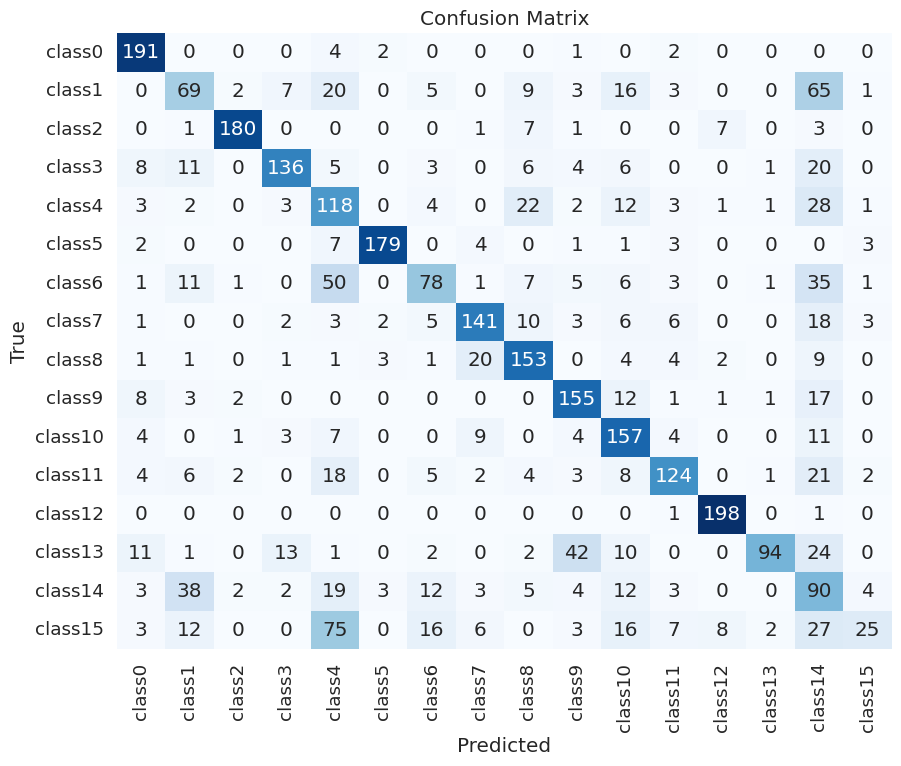

In [14]:
# Printing Confusion Matrix
class_names = ["class"+str(i) for i in range(16)]
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(CM, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()